<a href="https://colab.research.google.com/github/conceptree/p-gAnalytics-Prediction/blob/main/OEOD_P%26G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data-Driven Optimization Strategies

## P&G analysis and prediction

### Project Goals
• Define 2 trading strategies: one based on statistical/machine learning models
and the second one based on reinforcement learning algorithms for the historical
stock prices attributed to your group.
• Use at least two evaluation metrics (backtesting), and compare and interpret the obtained results.

### 1 Introduction

- Algorithmic trading (AT) refers to the process by which traders consistently buy and sell
one given financial asset to make profit. It is widely applied in trading stocks, commodity
futures and foreign exchanges.

- Trade-off between highest return and lowest risk : If an investor is expecting to invest in a riskier investment option than the risk-free rate then he/she is expecting to earn more in return.

### 1.1
- This is to compensate for the risk that the investor is taking.
- There exists a risk-free rate which is the rate that an investor earns on his/her investment without taking any risk.
- Refer to these transactions as assets.

### 1.2 What to do?
- Obtain/Extract the historical stock prices of the assets.
- Calculate the returns, expected mean returns, and the risk.
- Define statistical trading strategy (at least one, maximum 2).
- Evaluate the efficacy of the trading strategy.
- Use at least one reinforcement learning algorithm for trading the assets (Q-learning, deep Q-learning).
- Evaluate the efficacy of the trading strategy.
- Fine-tune your algorithms.
- Compare and interpret the results.

### 1.3 Report and Scripts
- Write a report (less than 25 pages) where you should have: an introduction, the project problem, methodology, data, results and conclusions.
- Please do not colocate Python outputs in the report (except for figures).
- All secondary information can be written in the Appendix.
- The Python Notebook ou Script without errors, with explicative comments, and able to run as-is.
- The report (in pdf format) and the Python file should be submitted to Moodle before the deadline (17 December, 2023)

### 1.4 Python Libraries
- pandas
- numpy
- matplotlib
- yfinance - download historical price data

### 2
- talib - technical indicators and analysis
- mplfinance - matplotlib utilities for financial data visualization
- backtesting

# Downloading stock data, calculating returns and risks, and visualizing the stock price:

In [39]:
!pip install stable-baselines3
!pip install 'shimmy>=0.2.1'

[*********************100%%**********************]  1 of 1 completed
Annual Return for AAPL: 9.94%
Annual Risk for AAPL: 22.53%


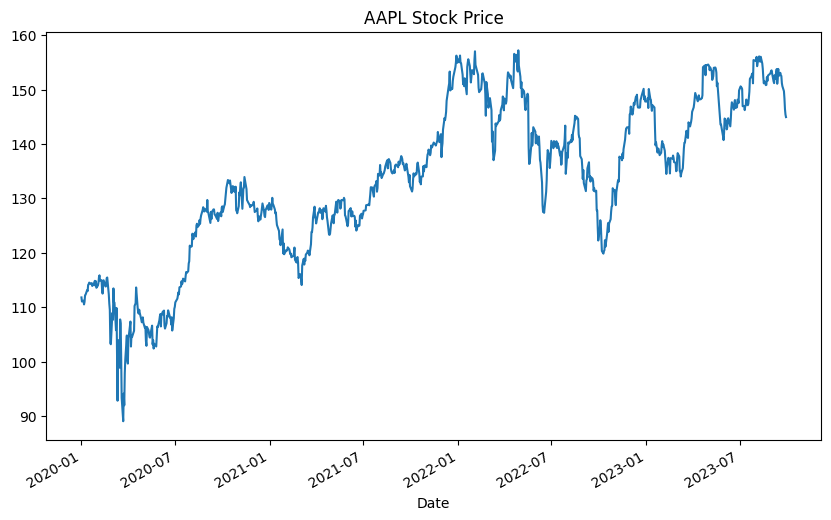

In [40]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import gym
from gym import spaces
from stable_baselines3 import DQN

pg_data = yf.download('PG', start='2020-01-01', end='2023-09-30')

# Define a function to download stock data and calculate returns and risks
def get_stock_data(ticker, start_date, end_date):
    # Download stock data
    stock_data = pg_data

    # Calculate daily returns
    daily_returns = stock_data['Adj Close'].pct_change()

    # Calculate expected returns (annualized)
    avg_daily_return = daily_returns.mean()
    annual_return = (1 + avg_daily_return) ** 252 - 1

    # Calculate risk (annualized standard deviation)
    daily_std = daily_returns.std()
    annual_risk = daily_std * (252 ** 0.5)

    return stock_data, annual_return, annual_risk

# Example usage
ticker = "AAPL"  # Apple Inc.
start_date = "2020-01-01"
end_date = "2021-01-01"

stock_data, annual_return, annual_risk = get_stock_data(ticker, start_date, end_date)

# Display results
print(f"Annual Return for {ticker}: {annual_return:.2%}")
print(f"Annual Risk for {ticker}: {annual_risk:.2%}")

# Plot stock data (Adjust Close price)
stock_data['Adj Close'].plot(title=f"{ticker} Stock Price", figsize=(10, 6))
plt.show()


# Statistical trading strategy
## Moving Average Crossover (MAC)

In [4]:
def calculate_moving_averages(stock_data, short_window, long_window):
    stock_data['Short_MA'] = stock_data['Close'].rolling(window=short_window, min_periods=1).mean()
    stock_data['Long_MA'] = stock_data['Close'].rolling(window=long_window, min_periods=1).mean()
    return stock_data


In [5]:
def calculate_moving_averages(stock_data, short_window, long_window):
    stock_data['Short_MA'] = stock_data['Close'].rolling(window=short_window, min_periods=1).mean()
    stock_data['Long_MA'] = stock_data['Close'].rolling(window=long_window, min_periods=1).mean()
    return stock_data


In [6]:
def generate_signals(stock_data):
    signals = pd.DataFrame(index=stock_data.index)
    signals['Signal'] = 0.0
    signals['Signal'] = np.where(stock_data['Short_MA'] > stock_data['Long_MA'], 1.0, 0.0)
    signals['Positions'] = signals['Signal'].diff()
    return signals


In [7]:
def plot_signals(stock_data, signals, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data['Close'], label=f'{ticker} Close Price', alpha=0.5)
    plt.plot(stock_data['Short_MA'], label='Short Moving Average', alpha=0.5)
    plt.plot(stock_data['Long_MA'], label='Long Moving Average', alpha=0.5)
    plt.scatter(signals.loc[signals.Positions == 1.0].index,
                stock_data['Short_MA'][signals.Positions == 1.0],
                label='Buy Signal', marker='^', color='green', s=100)
    plt.scatter(signals.loc[signals.Positions == -1.0].index,
                stock_data['Short_MA'][signals.Positions == -1.0],
                label='Sell Signal', marker='v', color='red', s=100)
    plt.title(f'{ticker} - Moving Average Crossover Strategy')
    plt.legend(loc='best')
    plt.show()


[*********************100%%**********************]  1 of 1 completed


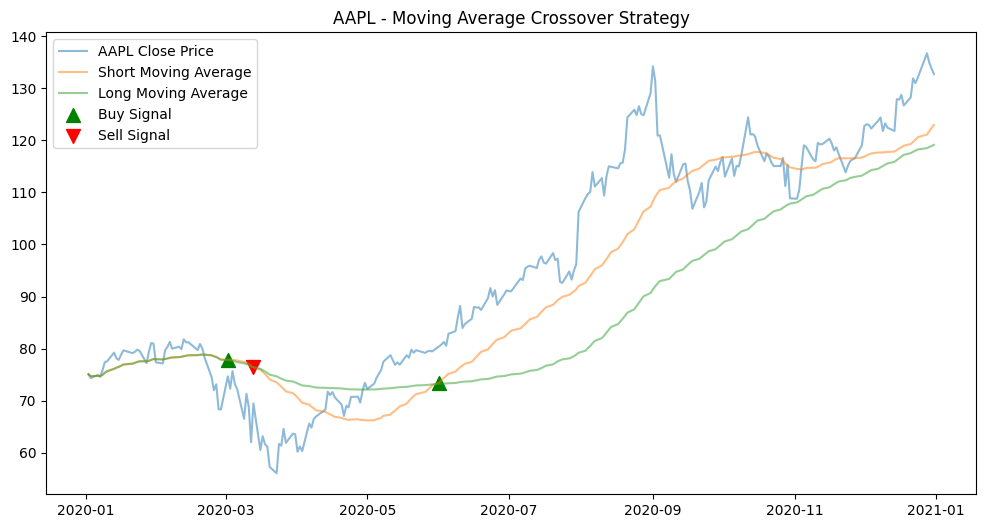

In [8]:
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2021-01-01'
short_window = 40
long_window = 100

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = calculate_moving_averages(stock_data, short_window, long_window)
signals = generate_signals(stock_data)
plot_signals(stock_data, signals, ticker)


# Q-Learning

In [41]:
class TradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(TradingEnv, self).__init__()

        self.data = data
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.position = 0
        self.current_step = 0

        # Define action and observation space
        self.action_space = spaces.Discrete(3)  # buy, sell, hold
        self.observation_space = spaces.Box(low=np.array([0, 0, 0]), high=np.array([np.inf, np.inf, np.inf]), dtype=np.float32)

    def reset(self):
        self.balance = self.initial_balance
        self.position = 0
        self.current_step = 0
        return self._get_state()

    def _get_state(self):
        return [self.data['Close'][self.current_step], self.position, self.balance]

    def step(self, action):
        current_price = self.data['Close'][self.current_step]
        reward = 0
        done = False
        info = {}

        if action == 0:  # buy
            if self.balance >= current_price:
                self.position += 1
                self.balance -= current_price
                reward = -current_price
        elif action == 1:  # sell
            if self.position > 0:
                self.position -= 1
                self.balance += current_price
                reward = current_price
        # action == 2 is hold, do nothing

        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            done = True

        return np.array(self._get_state()), reward, done, info


# Ensure you have the necessary data in pg_data
env = TradingEnv(pg_data)

model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Evaluate the trained agent
obs = env.reset()
for i in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    if dones:
        obs = env.reset()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 942      |
|    ep_rew_mean      | -2.3e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2316     |
|    time_elapsed     | 1        |
|    total_timesteps  | 3768     |
----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 942       |
|    ep_rew_mean      | -1.71e+03 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 8         |
|    fps              | 2330      |
|    time_elapsed     | 3         |
|    total_timesteps  | 7536      |
-----------------------------------


- rollout/ep_len_mean: The average length of an episode over the last few episodes. An episode length is the number of steps taken before the episode ends.
- rollout/ep_rew_mean: The average reward per episode over the last few episodes.
- rollout/exploration_rate: The current exploration rate of the agent. This rate affects how often the agent takes random actions, as opposed to actions it believes are best based on its current policy. It's part of the ε-greedy strategy.
- time/episodes: The total number of episodes completed so far.
- time/fps: The number of environment steps per second (frames per second).
- time/time_elapsed: The total training time in seconds.
- time/total_timesteps: The total number of timesteps (environment steps) taken so far.